# Satellite Image Analysis Challenge Challenge

## Task 1: Forest Disturbances

Preliminary solution outline:

1. Filter out cloudy images and correct the remaining images for solar illumination and atmospheric conditions differences.
2. Compute domain-related indices (e.g., NDVI, leaf area, bare soil and burn ratio)
3. Create preliminary areas of interest (aoi): considering a period of interest, subtract the first image from the last image (in all available bands and computed indices) to delineate areas of disturbance.
4. Create forest disturbance mask: using NDVI or other vegetation-enhancing index, identify which of the preliminary aio were considered to be forest areas in the first image (a threshold value can be set based on domain knowledge about the forest characteristics in the area). Label the resulting forest disturbance mask to identify non-connected aio. 
5. Predict time (i.e. month) of disturbance: for each aio in the forest disturbance mask, use statistics to extract information about the pixels' values (e.g., max, mean, sd) of sentinel bands in the different dates of image acquisitions. Predict time of occurrence based on (abrupt) variations of such measurements.
6. Classify disturbances into unique classes: based on the channel(s) that reacted the most to the disturbances and the observed change behaviour, group these disturbances into unique classes (e.g., pixels' value in the burn ratio channel increases after fires or pixels' value in the NDVI channel decreases after clearcuts).

Challenges: 
- Correct for variation caused by solar illumination, atmospheric conditions and viewing geometry differences.
- Sparse image acquisitions after filtering out images containing clouds or snow.
- Set the forest threshold value (e.g., possible trade-off between including young forests and excluding crop-related vegetation).

## Task 2: Image Segmentation

In [1]:
import os

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sentinelhub import SHConfig, MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, DataCollection, bbox_to_dimensions, DownloadRequest

In [2]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [3]:
aoi_coords_wgs84 = [28.5164960506072, 65.5625905564034, 28.8476328224876, 65.6486750602434]

In [4]:
resolution = 16
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: width = {aoi_size[0]} and height = {aoi_size[1]} pixels')

Image shape at 16 m resolution: width = 937 and height = 625 pixels


In [5]:
evalscript_allBands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 12,
                sampleType: "INT16"
            }
        };
    }

    function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {
        outputMetadata.userData = { "norm_factor":  inputMetadata.normalizationFactor }
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B11,
                sample.B12];
    }
"""

request_allBands_multitype = SentinelHubRequest(
    data_folder='./sentinelhub_data/',
    evalscript=evalscript_allBands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-06-01', '2020-07-30'),
            mosaicking_order='leastCC',
            upsampling='BICUBIC',
            downsampling='BICUBIC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
        SentinelHubRequest.output_response('userdata', MimeType.JSON)
    ],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config
)

In [6]:
save_data=True
allBands_multitype_response = request_allBands_multitype.get_data(save_data=save_data)

In [8]:
if (save_data):
    print(f'The output directory has been created and a tiff file with all 12 bands was saved into the following structure:\n')

    for folder, _, filenames in os.walk(request_allBands_multitype.data_folder):
        for filename in filenames:
            print(os.path.join(folder, filename))

The output directory has been created and a tiff file with all 12 bands was saved into the following structure:

./sentinelhub_data/.DS_Store
./sentinelhub_data/8e81fd271531b960afa87142d18b4e58/request.json
./sentinelhub_data/8e81fd271531b960afa87142d18b4e58/response.tar


In [9]:
multi_data = allBands_multitype_response[0]
multi_data.keys()

dict_keys(['default.tif', 'userdata.json'])

In [10]:
data = multi_data['default.tif']

print(f'- Downloaded data')
print(f'    Data type: {data.dtype}')
print(f'    Data shape: {data.shape}')
print(f'    Max = {np.max(data)}, Min = {np.min(data)}')

norm_factor = multi_data['userdata.json']['norm_factor']
data = data * norm_factor

print(f'\n- Transformed data')
print(f'    Data type: {data.dtype}')
print(f'    Data shape: {data.shape}')
print(f'    Max = {np.max(data)}, Min = {np.min(data)}')

- Downloaded data
    Data type: uint16
    Data shape: (625, 937, 12)
    Max = 6135, Min = 1

- Transformed data
    Data type: float64
    Data shape: (625, 937, 12)
    Max = 0.6135, Min = 0.0001


In [11]:
# Computation of NDVI:
numerator = data[:,:,7] - data[:,:,3]
denominator = data[:,:,7] + data[:,:,3] + 0.000000001
ndvi = numerator / denominator

print(f'- NDVI channel')
print(f'    Max = {np.max(ndvi):.4f}, Mean = {np.mean(ndvi):.4f}, Median = {np.median(ndvi):.4f}, Min = {np.min(ndvi):.4f}')

data = np.dstack([data, ndvi])

print(f'\n- Augmented data')
print(f'    Data type: {data.dtype}')
print(f'    Data shape: {data.shape}')

- NDVI channel
    Max = 0.9919, Mean = 0.5928, Median = 0.6694, Min = -0.9780

- Augmented data
    Data type: float64
    Data shape: (625, 937, 13)


In [12]:
print(f'- Basic statistics:')
bands = ['B01',"B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12", "NDVI"]
for counter, band in enumerate(bands):
    tmp = data[:,:,counter]
    print(f'    {band}: Max = {np.max(tmp):.4f}, Mean = {np.mean(tmp):.4f}, Median = {np.median(tmp):.4f}, Min = {np.min(tmp):.4f}')

- Basic statistics:
    B01: Max = 0.0778, Mean = 0.0131, Median = 0.0123, Min = 0.0001
    B02: Max = 0.1943, Mean = 0.0250, Median = 0.0231, Min = 0.0001
    B03: Max = 0.2137, Mean = 0.0416, Median = 0.0408, Min = 0.0001
    B04: Max = 0.2529, Mean = 0.0389, Median = 0.0331, Min = 0.0001
    B05: Max = 0.2549, Mean = 0.0808, Median = 0.0759, Min = 0.0001
    B06: Max = 0.4159, Mean = 0.1479, Median = 0.1537, Min = 0.0001
    B07: Max = 0.5086, Mean = 0.1698, Median = 0.1763, Min = 0.0001
    B08: Max = 0.6135, Mean = 0.1869, Median = 0.1926, Min = 0.0001
    B8A: Max = 0.5259, Mean = 0.1915, Median = 0.1975, Min = 0.0001
    B09: Max = 0.4604, Mean = 0.1940, Median = 0.2006, Min = 0.0001
    B11: Max = 0.4021, Mean = 0.1475, Median = 0.1510, Min = 0.0001
    B12: Max = 0.3767, Mean = 0.0862, Median = 0.0855, Min = 0.0001
    NDVI: Max = 0.9919, Mean = 0.5928, Median = 0.6694, Min = -0.9780


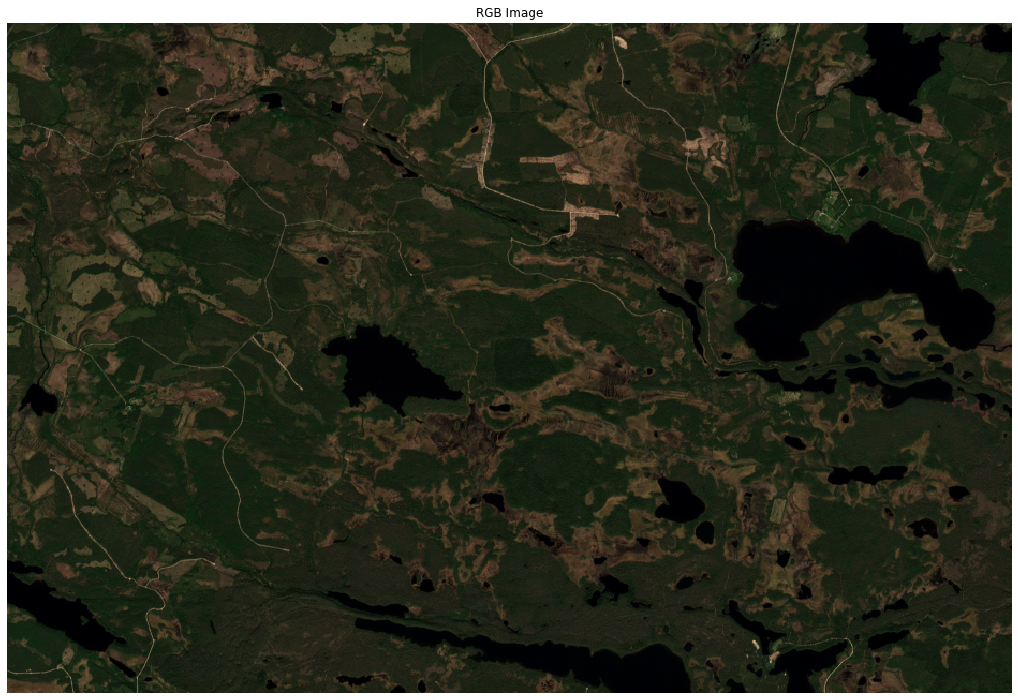

In [13]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(18, 14))

_ = ax0.imshow(np.clip(data[:,:, (3,2,1)]*3.5, a_min=0, a_max=1), interpolation='none')
_ = ax0.set_title('RGB Image')
_ = ax0.axis('off')

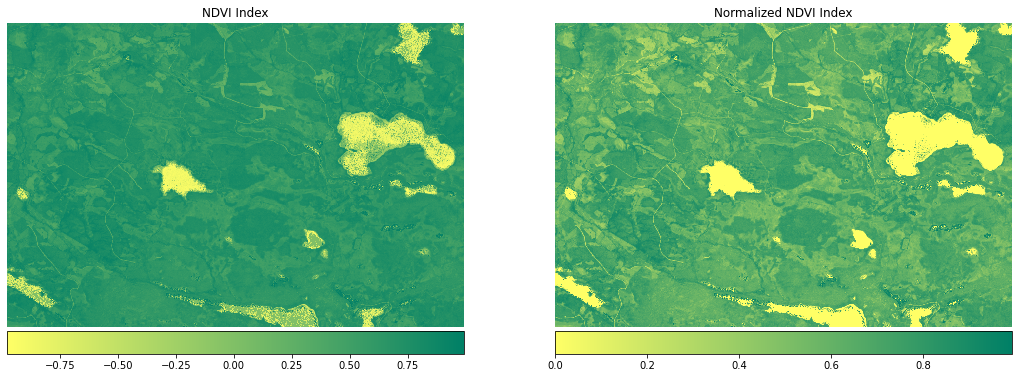

In [20]:
ndvi_norm = np.clip(a=data[:,:,-1], a_min=0, a_max=1.0, dtype=np.float64)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 14))

implot0 = ax0.imshow(data[:,:,-1], interpolation='none', cmap=cm.summer_r)
_ = ax0.set_title('NDVI Index')
_ = ax0.axis('off')
_ = fig.colorbar(implot0, ax=ax0, orientation='horizontal', pad=0.005)

implot1 = ax1.imshow(ndvi_norm, interpolation='none', cmap=cm.summer_r)
_ = ax1.set_title('Normalized NDVI Index')
_ = ax1.axis('off')
_ = fig.colorbar(implot1, ax=ax1, orientation='horizontal', pad=0.005)

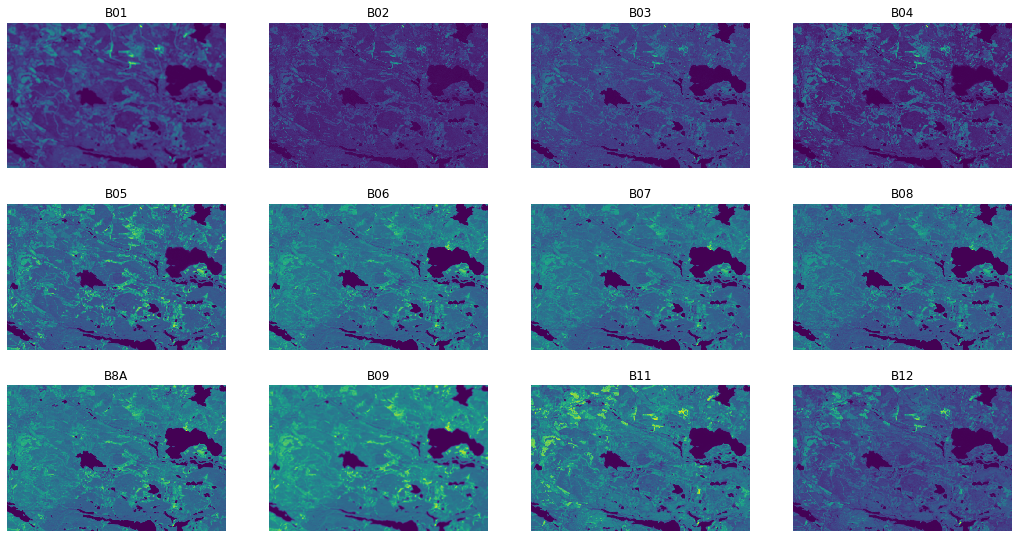

In [21]:

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 10))
for counter in range(len(bands)-1):
    _ = axs.flat[counter].imshow(data[:,:,counter], interpolation='none')
    _ = axs.flat[counter].set_title(f'{bands[counter]}')
    _ = axs.flat[counter].axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=0.)
plt.tight_layout
plt.show()

In [22]:
b11_norm = data[:,:,10] / np.max(data[:,:,10])
b11_inv = (b11_norm - 1)*(-1)

print(f'\n- Inv Normalized B11')
print(f'    Data type: {b11_inv.dtype}')
print(f'    Data shape: {b11_inv.shape}')
print(f'    Max = {np.max(b11_inv):.4f}, Mean = {np.mean(b11_inv):.4f}, Median = {np.median(b11_inv):.4f}, Min = {np.min(b11_inv):.4f}')


- Inv Normalized B11
    Data type: float64
    Data shape: (625, 937)
    Max = 0.9998, Mean = 0.6333, Median = 0.6245, Min = -0.0000


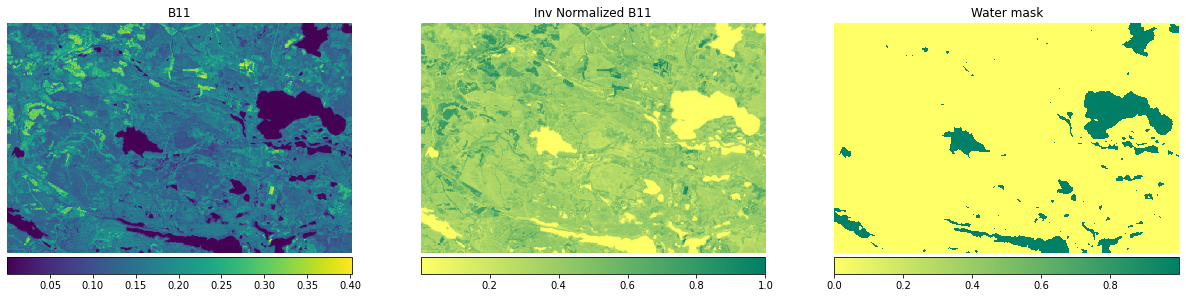

In [29]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(21, 14))

implot0 = ax0.imshow(data[:,:,10], interpolation='none')
_ = ax0.set_title('B11')
_ = ax0.axis('off')
_ = fig.colorbar(implot0, ax=ax0, orientation='horizontal', pad=0.005)

implot1 = ax1.imshow(b11_norm, interpolation='none', cmap=cm.summer_r)
_ = ax1.set_title('Inv Normalized B11')
_ = ax1.axis('off')
_ = fig.colorbar(implot1, ax=ax1, orientation='horizontal', pad=0.005)

b11_inv[b11_inv<0.95]=0

implot2 = ax2.imshow(b11_inv, interpolation='none', cmap=cm.summer_r)
_ = ax2.set_title('Water mask')
_ = ax2.axis('off')
_ = fig.colorbar(implot2, ax=ax2, orientation='horizontal', pad=0.005)

In [30]:
im = np.clip((ndvi_norm - b11_inv), a_min=0, a_max=1, dtype=np.float64)

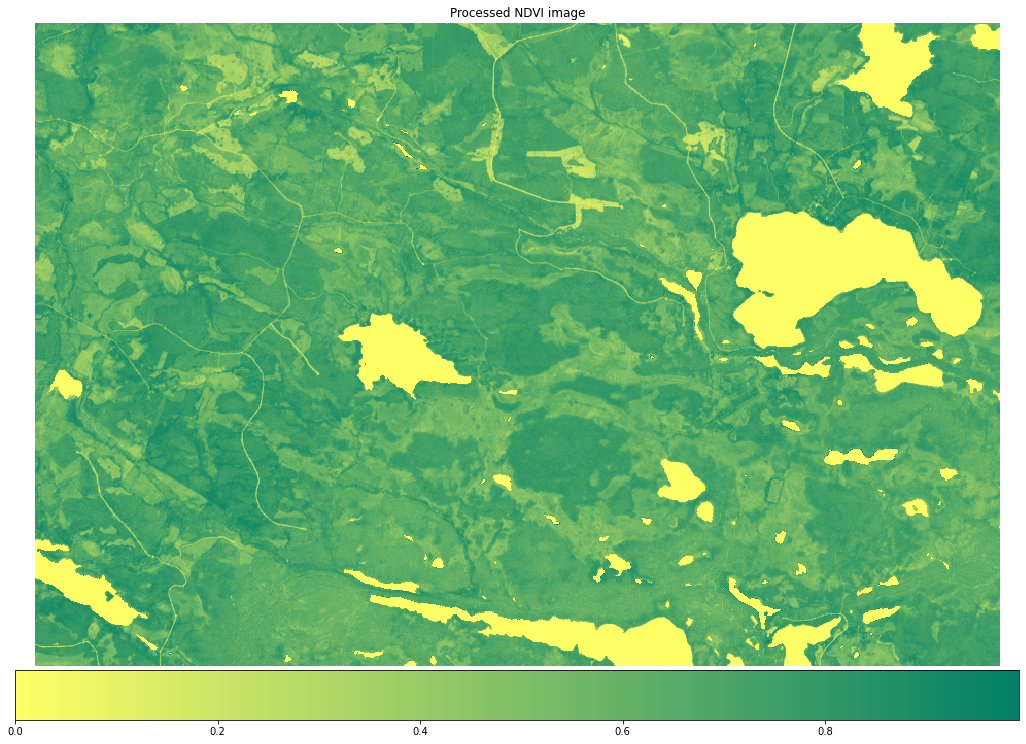

In [31]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(18, 14))

implot = ax0.imshow(im, interpolation='none', cmap=cm.summer_r)
_ = ax0.set_title('Processed NDVI Image')
_ = ax0.axis('off')
_ = fig.colorbar(implot, orientation='horizontal', pad=0.005)

In [38]:
def gamma_transf(im, gamma):
    lookUpTable = np.empty(shape=(1,256), dtype=np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(np.power(i / 255.0, gamma) * 255.0, 0, 255) # Gamma transformation
    return cv.LUT(im, lookUpTable) # performs a look-up table transform of an array

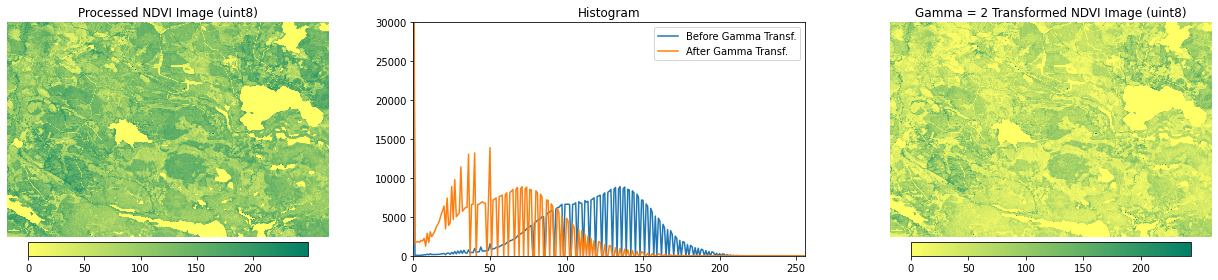

In [87]:
im_uint8 = (im*255).astype(np.uint8)
im_gamma2 = gamma_transf(im_uint8, gamma=2)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

implot = ax0.imshow(im_uint8, interpolation='none', cmap=cm.summer_r)
_ = ax0.set_title('Processed NDVI Image (uint8)')
_ = ax0.axis('off')
_ = fig.colorbar(implot, ax=ax0, fraction=0.06, orientation='horizontal', pad=0.02)

hist = cv.calcHist(images=[im_uint8], channels=[0], mask=None, histSize=[256], ranges=[0,256])
_ = ax1.plot(hist, label='Before Gamma Transf.')
_ = ax1.set_title('Histogram')

hist = cv.calcHist(images=[im_gamma2], channels=[0], mask=None, histSize=[256], ranges=[0,256])
_ = ax1.plot(hist, label='After Gamma Transf.')

_ = ax1.set_xlim([0,256])
_ = ax1.set_ylim([0,30000])
_ = ax1.legend()

implot = ax2.imshow(im_gamma2, interpolation='none', cmap=cm.summer_r)
_ = ax2.set_title('Gamma = 2 Transformed NDVI Image (uint8)')
_ = ax2.axis('off')
_ = fig.colorbar(implot, ax=ax2, fraction=0.06, orientation='horizontal', pad=0.02)

plt.tight_layout()

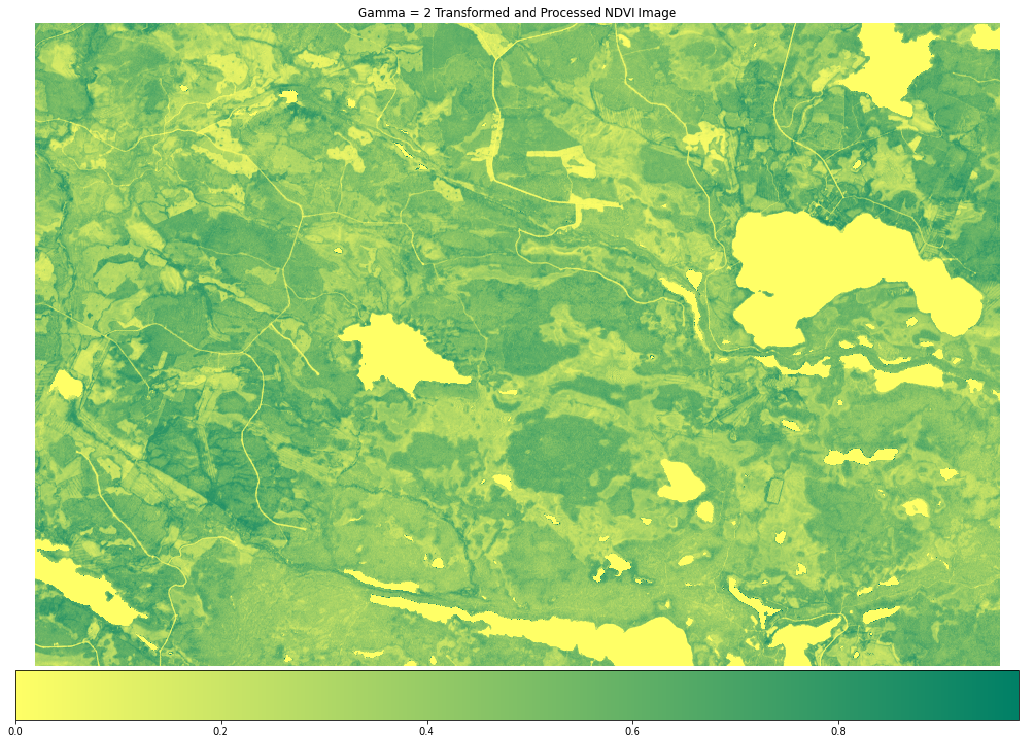

In [62]:
im = im_gamma2.astype(np.float64) / 255.0
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(18, 14))

implot = ax0.imshow(im, interpolation='none', cmap=cm.summer_r)
_ = ax0.set_title('Gamma = 2 Transformed and Processed NDVI Image')
_ = ax0.axis('off')
_ = fig.colorbar(implot, orientation='horizontal', pad=0.005)

In [91]:
# Hard-coded Thresholding
forest_threshold = 0.5
segmented_im = np.zeros(shape=(im.shape))
segmented_im[im>forest_threshold] = 1

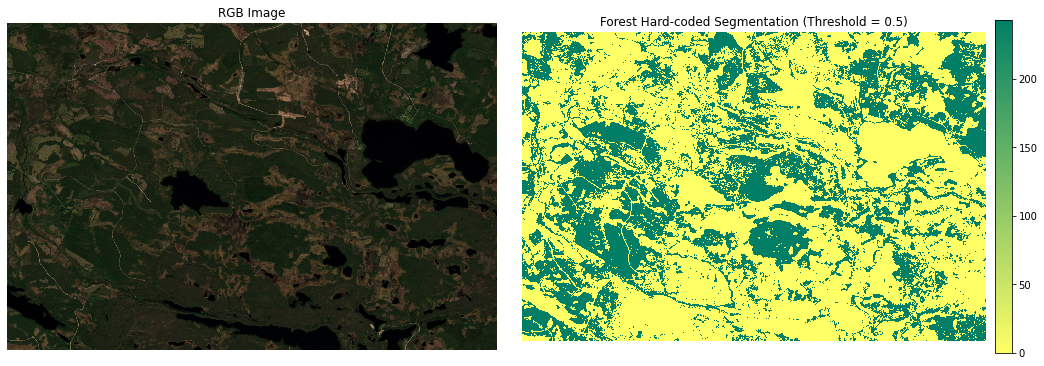

In [92]:
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 16))

implot0 = ax0.imshow(np.clip(data[:,:, (3,2,1)]*3.5, a_min=0, a_max=1), interpolation='none')
_ = ax0.set_title('RGB Image')
_ = ax0.axis('off')

implot1 = ax1.imshow(segmented_im, interpolation='none', cmap=cm.summer_r)
_ = ax1.set_title(f'Forest Hard-coded Segmentation (Threshold = {forest_threshold})')
_ = ax1.axis('off')
_ = fig.colorbar(implot, fraction=0.034, orientation='vertical', pad=0.02)

plt.subplots_adjust(wspace=0.05, hspace=0.)

In [ ]:

# kmeans = KMeans(n_clusters=2, n_init=10, random_state=100, copy_x=True).fit(im.reshape(im.shape[0]*im.shape[1], -1))
# ndvi > 0.8 and im[:,:,1]*3 < 0.1
forest_point = np.ones(shape=im.shape[:-1])
forest_point[ndvi < 0.8] = 0
forest_point[im[:,:,10] < 0.1] = 0

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

implot = ax0.imshow(im[:,:,(3,2,1)], interpolation='none', alpha=0.8)
implot = ax0.imshow(forest_point, interpolation='none', alpha=0.4)
ax0.set_title('Forest Ground Truth')
axis = ax0.axis('off')
cbar = fig.colorbar(implot)


x_coord, y_coord = forest_point.nonzero()
seed_f = np.random.choice(x_coord, size=1)
print(seed_f)
x_coord, y_coord = forest_point



In [ ]:
kmeans = KMeans(n_clusters=4, n_init=10, copy_x=True).fit(im.reshape(im.shape[0]*im.shape[1], -1))
labels=kmeans.labels_
test = labels.reshape(im.shape[0],im.shape[1])
print(test.shape)

In [ ]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(18, 16))

implot = ax0.imshow(test[:,:], interpolation='none', cmap=cm.summer_r)
ax0.set_title('PCA')
axis = ax0.axis('off')

In [ ]:
components=4
pca = PCA(n_components=components).fit(im.reshape(-1,im.shape[2]))
test = pca.transform(im.reshape(-1,im.shape[2])).reshape(im.shape[0], im.shape[1], components)

In [ ]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(18, 16))

implot = ax0.imshow(test[:,:,0], interpolation='none', cmap=cm.summer_r)
ax0.set_title('PCA')
axis = ax0.axis('off')

In [ ]:
labels = {1:'Others', 2:'Forest'}

data = np.zeros(shape=(im.shape[0], im.shape[1], 2), dtype=np.uint8)

# Water

data[10:20, 812:822] = [1,1]
data[215:225, 728:738] = [1,2]
data[440:450, 624:634] = [1,3]
data[340:360, 26:31] = [1,4]

# Roads

data[110:115, 635:640] = [1,5]
data[90:100, 858:864] = [1,6]
data[150:155, 822:838] = [1,7]
data[10:20, 437:447] = [1,8]
data[120:140, 187:192] = [1,9]
data[620:625, 0:30] = [1,10]
data[505:510, 530:540] = [1,11]

# Agriculture

data[70:85, 240:245] = [1,12]
data[315:330, 20:25] = [1,13]
data[93:98, 675:680] = [1,14]

# Forest

data[265:275, 150:160] = [2,15]
data[10:20, 400:410] = [2,16]
data[65:75, 426:437] = [2,17]
data[200:210, 171:181] = [2,18]
data[320:330, 473:483] = [2,19]

x_coord, y_coord = data[:,:,0].nonzero()

dict_data = {'PolygonID': data[x_coord, y_coord, 1],
     'B01': im[x_coord, y_coord, 0],
     'B02': im[x_coord, y_coord, 1],
     'B03': im[x_coord, y_coord, 2],
     'B04': im[x_coord, y_coord, 3],
     'B05': im[x_coord, y_coord, 4],
     'B06': im[x_coord, y_coord, 5],
     'B07': im[x_coord, y_coord, 6],
     'B08': im[x_coord, y_coord, 7],
     'B8A': im[x_coord, y_coord, 8],
     'B09': im[x_coord, y_coord, 9],
     'B11': im[x_coord, y_coord, 10],
     'B12': im[x_coord, y_coord, 11],
     'NDVI': im[x_coord, y_coord, 12],
     'Class': data[x_coord, y_coord, 0],
     'coord': zip(x_coord, y_coord)
     }

df_data = pd.DataFrame(data=dict_data, dtype=np.uint8)
df_data.info()

In [ ]:
def box_plot(x_train, y_train):
    tmp = x_train.drop(columns=['PolygonID','coord'], inplace=False)
    fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(20,8))
    for counter, feature in enumerate(tmp.columns):
        feature = tmp[f'{feature}']
        c1 = feature[y_train == 1]
        c2 = feature[y_train == 2]
        feature_dict = {'Others': c1, 'Forest': c2}

        axs.flat[counter].set_title(f'Boxplot Channel = {feature.name}')
        axs.flat[counter].boxplot(feature_dict.values())
        axs.flat[counter].set_xticklabels(feature_dict.keys())
    
    plt.tight_layout()
    plt.show()

In [ ]:
box_plot(x_train, y_train)